In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
file_path = "data/featured_clinvar_result.csv"
df = pd.read_csv(file_path)

# Define features (X) and target (y)
X = df.drop(columns=["label"])
y = df["label"]

# Display dataset info
print(f"Dataset shape: {df.shape}")
print(f"Feature count: {X.shape[1]}")
print(f"Class distribution:\n{y.value_counts()}")

Dataset shape: (1215, 23)
Feature count: 22
Class distribution:
label
0    632
1    583
Name: count, dtype: int64


In [3]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train-Test Split Done: {X_train.shape[0]} Train Samples, {X_test.shape[0]} Test Samples")

Train-Test Split Done: 972 Train Samples, 243 Test Samples


In [4]:
# Apply SMOTE oversampling to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Original class distribution:
label
0    506
1    466
Name: count, dtype: int64

Resampled class distribution:
label
0    506
1    506
Name: count, dtype: int64


In [5]:
# Define Optuna Study
def create_and_study_model(model_name, model_class, param_func, n_trials=50):
    """
    Create and optimize a model using Optuna.
    
    Args:
        model_name (str): Name of the model
        model_class: The model class to instantiate
        param_func: Function that generates model parameters for Optuna
        n_trials (int): Number of optimization trials
        
    Returns:
        tuple: Best model and study object
    """
    print(f"\n{'='*50}")
    print(f"Optimizing {model_name} with Optuna")
    print(f"{'='*50}")
    
    def objective(trial):
        # Get hyperparameters from param function
        params = param_func(trial)
        
        # Create model with the suggested hyperparameters
        model = model_class(**params)
        
        # Create pipeline with scaling and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Perform cross-validation
        scores = cross_val_score(
            pipeline, X_train_resampled, y_train_resampled, 
            cv=5, scoring='accuracy', n_jobs=-1
        )
        
        return scores.mean()
    
    # Create study object and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    # Get best parameters and create the best model
    best_params = study.best_params
    best_model = model_class(**best_params)
    
    # Print results
    print(f"\nBest {model_name} Parameters:")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    print(f"Best CV Score: {study.best_value:.4f}")
    
    return best_model, study

In [6]:
# Define Hyperparameter Search Spaces for Each Model
def logistic_regression_params(trial):
    return {
        'C': trial.suggest_float('C', 0.01, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': 1000,
        'random_state': 42
    }

def knn_params(trial):
    return {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 21, step=2),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'p': trial.suggest_int('p', 1, 2)
    }

def svm_params(trial):
    return {
        'C': trial.suggest_float('C', 0.01, 10.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'probability': True,
        'random_state': 42
    }

def decision_tree_params(trial):
    return {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42
    }

def random_forest_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }

def xgboost_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'eval_metric': 'logloss'
    }

def adaboost_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME']),
        'random_state': 42
    }

# This is a common fix for the CatBoost parameter error
def catboost_params(trial):
    return {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': False
    }

def gradient_boost_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }

In [7]:
# Run Optimization for Each Model
# Prepare list of models with their parameters
models_to_optimize = [
    ("Logistic Regression", LogisticRegression, logistic_regression_params),
    ("KNN", KNeighborsClassifier, knn_params),
    ("SVM", SVC, svm_params),
    ("Decision Tree", DecisionTreeClassifier, decision_tree_params),
    ("Random Forest", RandomForestClassifier, random_forest_params),
    ("XGBoost", XGBClassifier, xgboost_params),
    ("AdaBoost", AdaBoostClassifier, adaboost_params),
    ("CatBoost", CatBoostClassifier, catboost_params),
    ("Gradient Boosting", GradientBoostingClassifier, gradient_boost_params)
]

# This might take a while - adjust n_trials if needed
optimized_models = {}
for model_name, model_class, param_func in models_to_optimize:
    best_model, study = create_and_study_model(
        model_name, model_class, param_func, n_trials=30  # You can adjust n_trials based on your time constraints
    )
    optimized_models[model_name] = best_model

[I 2025-04-16 00:17:32,480] A new study created in memory with name: no-name-49d1fd1a-4505-42fd-8605-96bde7a4700b



Optimizing Logistic Regression with Optuna


[I 2025-04-16 00:17:33,976] Trial 0 finished with value: 0.8844169145978638 and parameters: {'C': 0.03692755039306469, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8844169145978638.
[I 2025-04-16 00:17:35,017] Trial 1 finished with value: 0.8873677022874702 and parameters: {'C': 0.2917488736798815, 'solver': 'liblinear'}. Best is trial 1 with value: 0.8873677022874702.
[I 2025-04-16 00:17:36,009] Trial 2 finished with value: 0.8844217919328878 and parameters: {'C': 0.023677625747095487, 'solver': 'saga'}. Best is trial 1 with value: 0.8873677022874702.
[I 2025-04-16 00:17:36,999] Trial 3 finished with value: 0.8844169145978638 and parameters: {'C': 0.047982538787365005, 'solver': 'saga'}. Best is trial 1 with value: 0.8873677022874702.
[I 2025-04-16 00:17:37,026] Trial 4 finished with value: 0.8814563722382089 and parameters: {'C': 0.015741354774243134, 'solver': 'liblinear'}. Best is trial 1 with value: 0.8873677022874702.
[I 2025-04-16 00:17:37,052] Trial 5 finished with val


Best Logistic Regression Parameters:
    C: 2.761787320089015
    solver: saga
Best CV Score: 0.8893

Optimizing KNN with Optuna


[I 2025-04-16 00:17:39,228] Trial 2 finished with value: 0.8755547968589962 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}. Best is trial 0 with value: 0.9130761351997269.
[I 2025-04-16 00:17:39,306] Trial 3 finished with value: 0.9219528849436667 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'auto', 'p': 1}. Best is trial 3 with value: 0.9219528849436667.
[I 2025-04-16 00:17:39,330] Trial 4 finished with value: 0.8883480466273228 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2}. Best is trial 3 with value: 0.9219528849436667.
[I 2025-04-16 00:17:39,355] Trial 5 finished with value: 0.9150319465444081 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 2}. Best is trial 3 with value: 0.9219528849436667.
[I 2025-04-16 00:17:39,391] Trial 6 finished with value: 0.8784958298785543 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'algorithm


Best KNN Parameters:
    n_neighbors: 17
    weights: distance
    algorithm: kd_tree
    p: 1
Best CV Score: 0.9299

Optimizing SVM with Optuna


[I 2025-04-16 00:17:40,647] Trial 2 finished with value: 0.8794517875432863 and parameters: {'C': 1.4891639139474968, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.8903379993171731.
[I 2025-04-16 00:17:40,714] Trial 3 finished with value: 0.8814319855630883 and parameters: {'C': 0.054788624124952286, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8903379993171731.
[I 2025-04-16 00:17:40,770] Trial 4 finished with value: 0.9150465785494806 and parameters: {'C': 6.761930539467987, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 4 with value: 0.9150465785494806.
[I 2025-04-16 00:17:40,826] Trial 5 finished with value: 0.8607033117104814 and parameters: {'C': 0.012158481122780326, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 4 with value: 0.9150465785494806.
[I 2025-04-16 00:17:40,902] Trial 6 finished with value: 0.7685850851094962 and parameters: {'C': 0.023897689208210837, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 4 with valu


Best SVM Parameters:
    C: 4.336529717912693
    kernel: rbf
    gamma: scale
Best CV Score: 0.9229

Optimizing Decision Tree with Optuna


[I 2025-04-16 00:17:43,035] Trial 6 finished with value: 0.9377261864117447 and parameters: {'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 6 with value: 0.9377261864117447.
[I 2025-04-16 00:17:43,061] Trial 7 finished with value: 0.8765253865288006 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 6 with value: 0.9377261864117447.
[I 2025-04-16 00:17:43,089] Trial 8 finished with value: 0.9357654977320392 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 6 with value: 0.9377261864117447.
[I 2025-04-16 00:17:43,116] Trial 9 finished with value: 0.9238989416182998 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 6 with value: 0.9377261864117447.
[I 2025-04-16 00:17:43,151] Trial 10 finished with value: 0.923903818953324 and param


Best Decision Tree Parameters:
    max_depth: 13
    min_samples_split: 18
    min_samples_leaf: 2
    criterion: gini
Best CV Score: 0.9417

Optimizing Random Forest with Optuna


[I 2025-04-16 00:17:44,196] Trial 0 finished with value: 0.9298200263376092 and parameters: {'n_estimators': 204, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.9298200263376092.
[I 2025-04-16 00:17:44,480] Trial 1 finished with value: 0.8863873579476174 and parameters: {'n_estimators': 256, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 0 with value: 0.9298200263376092.
[I 2025-04-16 00:17:44,599] Trial 2 finished with value: 0.9298200263376092 and parameters: {'n_estimators': 64, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 0 with value: 0.9298200263376092.
[I 2025-04-16 00:17:44,873] Trial 3 finished with value: 0.9337901770472614 and parameters: {'n_estimators': 167, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 3 with value: 0.9337901770472614.
[I 2025-04-16 0


Best Random Forest Parameters:
    n_estimators: 127
    max_depth: 18
    min_samples_split: 11
    min_samples_leaf: 2
    bootstrap: False
Best CV Score: 0.9457

Optimizing XGBoost with Optuna


[I 2025-04-16 00:17:49,964] Trial 0 finished with value: 0.9397307711066674 and parameters: {'n_estimators': 287, 'max_depth': 4, 'learning_rate': 0.2736592740543102, 'subsample': 0.624473799525031, 'colsample_bytree': 0.9676619235043342, 'gamma': 2.340698317856063}. Best is trial 0 with value: 0.9397307711066674.
[I 2025-04-16 00:17:50,230] Trial 1 finished with value: 0.9367555967419403 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.1353872984485788, 'subsample': 0.8098033211480307, 'colsample_bytree': 0.7847762352506795, 'gamma': 0.01919214103540956}. Best is trial 0 with value: 0.9397307711066674.
[I 2025-04-16 00:17:50,464] Trial 2 finished with value: 0.8952641076915573 and parameters: {'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.01355259173482302, 'subsample': 0.9036311546708585, 'colsample_bytree': 0.7247240321367717, 'gamma': 1.9347716375493385}. Best is trial 0 with value: 0.9397307711066674.
[I 2025-04-16 00:17:50,594] Trial 3 finished w


Best XGBoost Parameters:
    n_estimators: 297
    max_depth: 7
    learning_rate: 0.07838484203899741
    subsample: 0.6015564326045225
    colsample_bytree: 0.9188991984265765
    gamma: 0.8063626185656766
Best CV Score: 0.9437

Optimizing AdaBoost with Optuna


[I 2025-04-16 00:17:53,122] Trial 0 finished with value: 0.9100960834999757 and parameters: {'n_estimators': 201, 'learning_rate': 0.9997342305475111, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.9100960834999757.
[I 2025-04-16 00:17:53,313] Trial 1 finished with value: 0.8873872116275667 and parameters: {'n_estimators': 101, 'learning_rate': 0.9130636935216742, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.9100960834999757.
[I 2025-04-16 00:17:53,432] Trial 2 finished with value: 0.8715505048041751 and parameters: {'n_estimators': 66, 'learning_rate': 0.290227039108982, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.9100960834999757.
[I 2025-04-16 00:17:53,698] Trial 3 finished with value: 0.8804565185582598 and parameters: {'n_estimators': 155, 'learning_rate': 0.45770342090685556, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.9100960834999757.
[I 2025-04-16 00:17:53,837] Trial 4 finished with value: 0.8853923816026923 and parameters: {'n_estimators': 68, 


Best AdaBoost Parameters:
    n_estimators: 201
    learning_rate: 0.9997342305475111
    algorithm: SAMME
Best CV Score: 0.9101

Optimizing CatBoost with Optuna


[I 2025-04-16 00:18:04,555] Trial 0 finished with value: 0.9446471248110033 and parameters: {'iterations': 258, 'depth': 6, 'learning_rate': 0.04749053621402744, 'l2_leaf_reg': 3.731259857519189}. Best is trial 0 with value: 0.9446471248110033.
[I 2025-04-16 00:18:05,452] Trial 1 finished with value: 0.9426718041262255 and parameters: {'iterations': 155, 'depth': 4, 'learning_rate': 0.1038817619945867, 'l2_leaf_reg': 4.550780359315283}. Best is trial 0 with value: 0.9446471248110033.
[I 2025-04-16 00:18:06,620] Trial 2 finished with value: 0.9426766814612495 and parameters: {'iterations': 200, 'depth': 7, 'learning_rate': 0.18013001064572043, 'l2_leaf_reg': 3.010871154602156}. Best is trial 0 with value: 0.9446471248110033.
[I 2025-04-16 00:18:07,660] Trial 3 finished with value: 0.9436521484660781 and parameters: {'iterations': 126, 'depth': 7, 'learning_rate': 0.083679466469285, 'l2_leaf_reg': 5.222458332311583}. Best is trial 0 with value: 0.9446471248110033.
[I 2025-04-16 00:18:08,


Best CatBoost Parameters:
    iterations: 68
    depth: 10
    learning_rate: 0.2591448106687291
    l2_leaf_reg: 6.96968898008027
Best CV Score: 0.9506

Optimizing Gradient Boosting with Optuna


[I 2025-04-16 00:18:33,279] Trial 0 finished with value: 0.9407208701165682 and parameters: {'n_estimators': 146, 'learning_rate': 0.18595803670688454, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 7, 'subsample': 0.8093435324321129}. Best is trial 0 with value: 0.9407208701165682.
[I 2025-04-16 00:18:33,514] Trial 1 finished with value: 0.9357654977320392 and parameters: {'n_estimators': 58, 'learning_rate': 0.2613978106984378, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.7088451542106033}. Best is trial 0 with value: 0.9407208701165682.
[I 2025-04-16 00:18:34,443] Trial 2 finished with value: 0.9407062381114958 and parameters: {'n_estimators': 213, 'learning_rate': 0.10355176781476791, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 4, 'subsample': 0.9485074706158517}. Best is trial 0 with value: 0.9407208701165682.
[I 2025-04-16 00:18:35,486] Trial 3 finished with value: 0.9476174218407062 and parameters: {'n_estimators'


Best Gradient Boosting Parameters:
    n_estimators: 261
    learning_rate: 0.23397724919029564
    max_depth: 5
    min_samples_split: 17
    min_samples_leaf: 3
    subsample: 0.6117892496781778
Best CV Score: 0.9546


In [8]:
# Create and Train Final Pipelines
results = {}
model_pipelines = {}

for model_name, model in optimized_models.items():
    print(f"\n{'='*50}")
    print(f"Training final {model_name} model")
    print(f"{'='*50}")
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Train the model and measure time
    start_time = time.time()
    pipeline.fit(X_train_resampled, y_train_resampled)
    training_time = time.time() - start_time
    
    # Make predictions and measure time
    start_time = time.time()
    y_pred = pipeline.predict(X_test)
    inference_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'training_time': training_time,
        'inference_time': inference_time,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
    
    # Store pipeline
    model_pipelines[model_name] = pipeline
    
    # Print results
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Inference Time: {inference_time:.4f} seconds")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)


Training final Logistic Regression model
Logistic Regression Accuracy: 0.8807
Training Time: 0.0185 seconds
Inference Time: 0.0000 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       126
           1       0.91      0.84      0.87       117

    accuracy                           0.88       243
   macro avg       0.88      0.88      0.88       243
weighted avg       0.88      0.88      0.88       243


Confusion Matrix:
[[116  10]
 [ 19  98]]

Training final KNN model
KNN Accuracy: 0.9342
Training Time: 0.0047 seconds
Inference Time: 0.0060 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       126
           1       0.92      0.95      0.93       117

    accuracy                           0.93       243
   macro avg       0.93      0.93      0.93       243
weighted avg       0.93      0.93      0.93       243


Confusi

In [9]:
#  Compare Model Performance
# Extract accuracies and times
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
training_times = [results[name]['training_time'] for name in model_names]
inference_times = [results[name]['inference_time'] for name in model_names]

# Create dataframe for comparison
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Training Time (s)': training_times,
    'Inference Time (s)': inference_times
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Display comparison
print("Model Comparison:")
print(comparison_df)

Model Comparison:
                 Model  Accuracy  Training Time (s)  Inference Time (s)
0    Gradient Boosting  0.971193           0.490096            0.005099
1             CatBoost  0.958848           0.747083            0.000000
2              XGBoost  0.958848           0.204329            0.004006
3        Decision Tree  0.950617           0.000000            0.000000
4        Random Forest  0.950617           0.134963            0.007597
5             AdaBoost  0.942387           0.308315            0.020703
6                  KNN  0.934156           0.004663            0.006005
7                  SVM  0.921811           0.000000            0.016474
8  Logistic Regression  0.880658           0.018461            0.000000


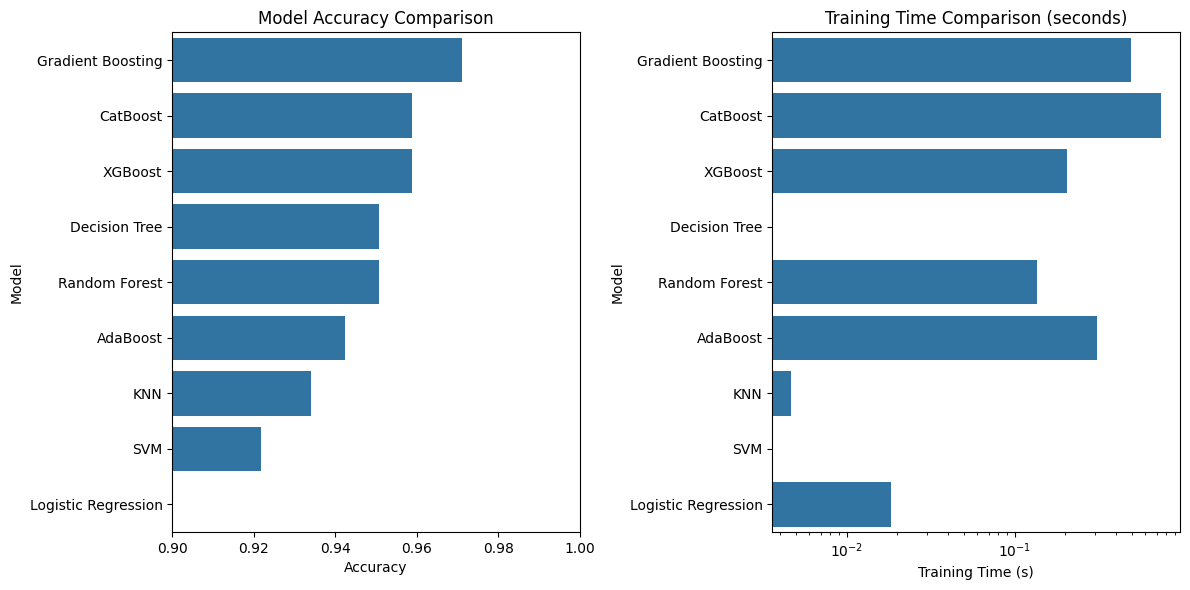

In [10]:
# Visualize Results
plt.figure(figsize=(12, 6))

# Plot accuracies
plt.subplot(1, 2, 1)
sns.barplot(y='Model', x='Accuracy', data=comparison_df)
plt.title('Model Accuracy Comparison')
plt.xlim(0.9, 1.0)  # Adjust as needed

# Plot training times (log scale)
plt.subplot(1, 2, 2)
sns.barplot(y='Model', x='Training Time (s)', data=comparison_df)
plt.title('Training Time Comparison (seconds)')
plt.xscale('log')

plt.tight_layout()
plt.show()

Model Metrics Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0    Gradient Boosting  0.971193   0.971217  0.971193  0.971189
1             CatBoost  0.958848   0.959395  0.958848  0.958862
2              XGBoost  0.958848   0.958848  0.958848  0.958848
3        Decision Tree  0.950617   0.951633  0.950617  0.950542
4        Random Forest  0.950617   0.951166  0.950617  0.950634
5             AdaBoost  0.942387   0.942387  0.942387  0.942387
6                  KNN  0.934156   0.934707  0.934156  0.934179
7                  SVM  0.921811   0.921863  0.921811  0.921821
8  Logistic Regression  0.880658   0.882442  0.880658  0.880329


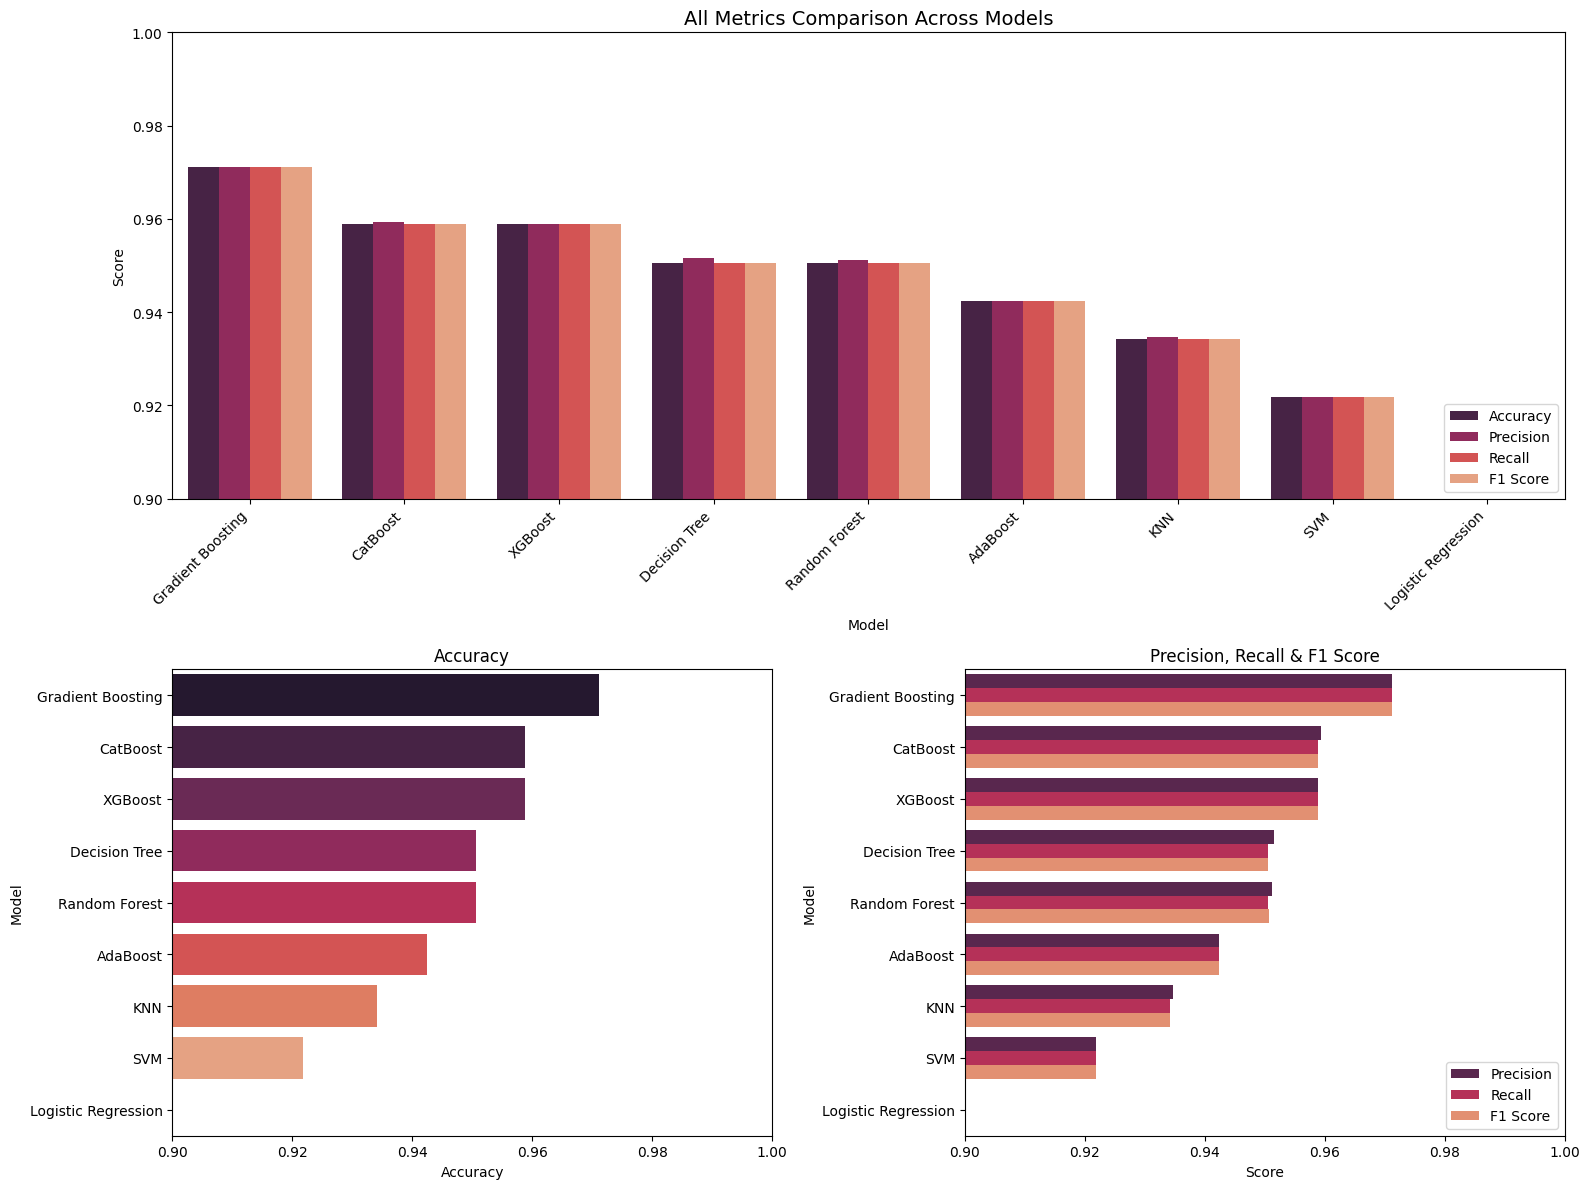

In [11]:
# Extract and Visualize All Metrics (Accuracy, Precision, Recall, F1)
# Calculate precision, recall, and F1 for each model
metrics_data = []

for model_name, result in results.items():
    y_pred = model_pipelines[model_name].predict(X_test)
    
    # Calculate metrics for each class (binary classification)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    # Calculate weighted metrics (overall)
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Add to data
    metrics_data.append({
        'Model': model_name,
        'Accuracy': result['accuracy'],
        'Precision': precision_weighted,
        'Recall': recall_weighted,
        'F1 Score': f1_weighted
    })

# Create dataframe
metrics_df = pd.DataFrame(metrics_data)

# Sort by accuracy
metrics_df = metrics_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Display comparison
print("Model Metrics Comparison:")
print(metrics_df)

# Prepare data for plotting
plot_data = pd.melt(metrics_df, 
                    id_vars=['Model'], 
                    value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                    var_name='Metric', 
                    value_name='Score')

# Create a figure with subplots
plt.figure(figsize=(16, 12))

# Plot all metrics in one chart
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='Score', hue='Metric', data=plot_data, palette='rocket')
plt.title('All Metrics Comparison Across Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.9, 1.0)  # Adjust as needed
plt.legend(loc='lower right')

# Individual metrics plots
plt.subplot(2, 2, 3)
sns.barplot(y='Model', x='Accuracy', data=metrics_df, palette='rocket')
plt.title('Accuracy', fontsize=12)
plt.xlim(0.9, 1.0)  # Adjust as needed

plt.subplot(2, 2, 4)
metrics_melted = pd.melt(metrics_df, 
                         id_vars=['Model'], 
                         value_vars=['Precision', 'Recall', 'F1 Score'],
                         var_name='Metric', 
                         value_name='Score')
sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_melted, palette='rocket')
plt.title('Precision, Recall & F1 Score', fontsize=12)
plt.xlim(0.9, 1.0)  # Adjust as needed
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('model_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Create a detailed table for each model
# Converting classification reports to DataFrames
model_metrics_detailed = {}

for model_name, result in results.items():
    # Parse classification report
    report_lines = result['classification_report'].split('\n')
    header = None
    data = []
    
    for line in report_lines:
        if not line.strip():
            continue
            
        if header is None:
            header = ['Class'] + line.strip().split()
            continue
        
        items = line.strip().split()
        if len(items) >= 5:  # Class line with metrics
            try:
                class_name = items[0]
                precision = float(items[1])
                recall = float(items[2])
                f1 = float(items[3])
                support = int(items[4])
                data.append([class_name, precision, recall, f1, support])
            except (ValueError, IndexError):
                continue
    
    if header and data:
        model_metrics_detailed[model_name] = pd.DataFrame(data, columns=header)

# Save detailed metrics to CSV
detailed_metrics_path = "model_detailed_metrics.csv"
with open(detailed_metrics_path, 'w') as f:
    for model_name, df in model_metrics_detailed.items():
        f.write(f"{model_name}\n")
        df.to_csv(f, index=False)
        f.write("\n\n")

print(f"Detailed metrics saved to: {detailed_metrics_path}")
print(f"Visualization saved to: model_metrics_comparison.png")

# Cell 12: Save Best Model
# Get the best model based on accuracy
best_model_name = comparison_df.iloc[0]['Model']
best_pipeline = model_pipelines[best_model_name]

# Save the model
best_model_path = f"models/best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_pipeline, best_model_path)

print(f"Best Model ({best_model_name}) Saved at: {best_model_path}")

# Save all models
for name, pipeline in model_pipelines.items():
    model_path = f"models/{name.replace(' ', '_').lower()}.pkl"
    joblib.dump(pipeline, model_path)
    print(f"{name} Model Saved at: {model_path}")

# Cell 13: Load and Use the Best Model (Example)
# Here's how you would load and use the saved model
loaded_model = joblib.load(best_model_path)

# Make predictions with the loaded model
predictions = loaded_model.predict(X_test)
print(f"\nLoaded model accuracy: {accuracy_score(y_test, predictions):.4f}")

Detailed metrics saved to: model_detailed_metrics.csv
Visualization saved to: model_metrics_comparison.png
Best Model (Gradient Boosting) Saved at: models/best_model_gradient_boosting.pkl
Logistic Regression Model Saved at: models/logistic_regression.pkl
KNN Model Saved at: models/knn.pkl
SVM Model Saved at: models/svm.pkl
Decision Tree Model Saved at: models/decision_tree.pkl
Random Forest Model Saved at: models/random_forest.pkl
XGBoost Model Saved at: models/xgboost.pkl
AdaBoost Model Saved at: models/adaboost.pkl
CatBoost Model Saved at: models/catboost.pkl
Gradient Boosting Model Saved at: models/gradient_boosting.pkl

Loaded model accuracy: 0.9712
